In [1]:
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import pandas as pd
from tqdm import tqdm

In [2]:
!dir

 El volumen de la unidad C es Local Disk
 El n£mero de serie del volumen es: 78AA-5A8A

 Directorio de C:\Users\n_940\Documents\UNAL\Temporal_U_Militar\desikan-killiany

09/09/2021  06:14 p. m.    <DIR>          .
09/09/2021  06:14 p. m.    <DIR>          ..
09/09/2021  06:14 p. m.    <DIR>          .ipynb_checkpoints
07/09/2021  05:38 p. m.             1.926 aal to HO.csv
22/07/2021  10:02 p. m.            13.538 aal-comparison-HO-noreg.csv
06/09/2021  08:13 p. m.            13.230 aal-comparison-HO-ref-A.csv
06/09/2021  08:38 p. m.            13.209 aal-comparison-HO-ref-B.csv
04/08/2021  09:02 p. m.            13.238 aal-comparison-HO.csv
04/08/2021  08:37 p. m.             5.923 aal_ho_difference.json
07/09/2021  05:37 p. m.           749.766 aal_transformed_roi.nii.gz
22/07/2021  10:14 p. m.            15.557 aicha-comparison-HO-noreg.csv
23/07/2021  05:47 p. m.            31.505 aicha-comparison-HO.csv
06/09/2021  08:40 p. m.           113.721 Atlas volumes regions.ipynb
13/07/20

In [3]:
template = nib.load('MNI152_T1_1mm_brain.nii.gz').get_fdata()
MNI_vol = (template>0).sum()
print('volumen MNI 152: ', (template>0).sum())
print('volumen todo archivo: ', (template>-1).sum())

volumen MNI 152:  1827095
volumen todo archivo:  7221032


In [4]:
desikan = nib.load('atlas_desikan_killiany.nii.gz').get_fdata()
num_region = 1028
desikan_reg = (desikan==num_region).sum()
print('desikan reg: ', desikan_reg)
print('desikan reg norm: ', (desikan_reg/MNI_vol))

desikan reg:  23562
desikan reg norm:  0.012895881166551274


In [5]:

desikan_new = nib.load('desikan_seg.nii.gz').get_fdata()
num_region = 18
desikan_reg_n = (desikan_new==num_region).sum()
print('new desikan reg: ', desikan_reg_n)
print('new desikan reg norm: ', desikan_reg_n/MNI_vol)

new desikan reg:  1213
new desikan reg norm:  0.0006638954186837575


In [6]:
harvard_oxford_cor = nib.load(os.path.join('harvard-oxford', 'HarvardOxford-cortl-maxprob-thr25-1mm.nii.gz')).get_fdata()
harvard_oxford_sub = nib.load(os.path.join('harvard-oxford', 'HarvardOxford-sub-maxprob-thr50-1mm.nii.gz')).get_fdata()

In [7]:
num_h_cort_reg = 51
harvard_cort_reg = (harvard_oxford_cor == num_h_cort_reg).sum()
print('harvard cort region: ', harvard_cort_reg)
print('harvard cort region norm: ', (harvard_cort_reg/MNI_vol))

harvard cort region:  5906
harvard cort region norm:  0.0032324537038303973


In [8]:
num_sub_reg = 20
harvard_sub_reg = (harvard_oxford_sub == num_sub_reg).sum()
print('harvard sub region: ', harvard_sub_reg)
print('harvard sub region norm: ', (harvard_sub_reg/MNI_vol))

harvard sub region:  2272
harvard sub region norm:  0.001243504032357376


In [9]:
def add_one_vox_pad(vol):
    h,w,k=vol.shape
    new_vol = np.zeros((h+1,w+1,k+1))
    new_vol[:h,:w,:k]=vol
    return new_vol

In [10]:
#aal = add_one_vox_pad(nib.load('new atlas/AAL3v1_for_SPM12 (1)/AAL3/ROI_MNI_V7_1mm.nii').get_fdata())
aal = nib.load('aal_transformed_roi.nii.gz').get_fdata()
aicha = add_one_vox_pad(nib.load('new atlas/AICHA_v2/AICHA/AICHA1mm.nii').get_fdata())
destrieux = nib.load('otros atlas/atlas_destrieux.nii.gz').get_fdata()
#neuro = nib.load('atlas_correc/neuromorphometrics_seg.nii.gz').get_fdata()

In [11]:
from nibabel.orientations import apply_orientation, io_orientation, ornt_transform
aal_raw = nib.load('new atlas/AAL3v1_for_SPM12 (1)/AAL3/ROI_MNI_V7_1mm.nii')
aal_affine = aal_raw.affine
io_aal = io_orientation(aal_affine)

print(io_aal)



[[0. 1.]
 [1. 1.]
 [2. 1.]]


In [12]:
ho_raw = nib.load(os.path.join('harvard-oxford', 'HarvardOxford-sub-maxprob-thr50-1mm.nii.gz'))
io_ho = io_orientation(ho_raw.affine)
transform = ornt_transform(io_aal,io_ho)
aal_transformed = add_one_vox_pad(apply_orientation(aal_raw.get_fdata(), transform))

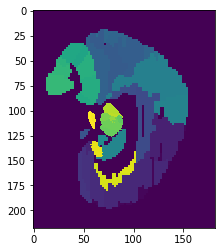

In [13]:
plt.imshow(aal_transformed[100,:,:])

## 2 Compute dice score between HO and DKT regions
We'll use binary masks to compute the dice score between a HO and a DKT region as $$ IoU(A,B) = \frac{A\cap B}{A\cup B} $$

In [14]:
def IoU(A,B):
    union = ((A+B)>0).astype(np.uint8)
    intersection = A*B
    return intersection.sum() / union.sum()

In [15]:
def dice_score(A,B):
    intersection = A*B
    num_elems = A.sum() + B.sum()
    return 2*intersection.sum() / num_elems

In [16]:
def probability_ref_A(A,B):
    intersection = A*B
    num_elems = A.sum()
    return intersection.sum() / num_elems

In [17]:
def probability_ref_B(A,B):
    intersection = A*B
    num_elems = B.sum()
    return intersection.sum() / num_elems

In [18]:
def select_atlas(atlas_name, atlases=[harvard_oxford_cor, harvard_oxford_sub, desikan_new,
                                     aal, aicha, destrieux]):
    if atlas_name=='harvard-cortical':
        return atlases[0]
    if atlas_name=='harvard-sub':
        return atlases[1]
    if atlas_name=='desikan':
        return atlases[2]
    if atlas_name=='aal':
        return atlases[3]
    if atlas_name=='aicha':
        return atlases[4]
    if atlas_name=='destrieux':
        return atlases[5]
    #if atlas_name=='neuro':
     #   return atlases[6]

In [19]:
def obtain_region_mask(region_group, template=template):
    mask = np.zeros(template.shape)
    for r in region_group:
        atlas = select_atlas(r['atlas'])
        num = r['region_number']
        mask+=((atlas==num).astype(np.uint8))
    return (mask>0).astype(np.uint8)

In [20]:
def compare_region_groups(A,B):
    gA = obtain_region_mask(A)
    gB = obtain_region_mask(B)
    return dice_score(gA, gB), IoU(gA,gB), probability_ref_A(gA, gB), probability_ref_B(gA, gB)

In [21]:
def obtain_region_volume(A):
    gA = obtain_region_mask(A)
    return gA.sum()

In [22]:
rA = [{'region_name': 'left amygdala', 'region_number': 10, 'atlas':'harvard-sub'}]
rB = [{'region_name': 'left amygdala', 'region_number': 18, 'atlas':'desikan'}]

In [23]:
compare_region_groups(rA, rB)

(0.6491392801251956,
 0.48053753475440225,
 0.5232088799192735,
 0.8549051937345424)

In [24]:
rA = [{'region_name': 'right amygdala', 'region_number': 10, 'atlas':'harvard-sub'}]
rB = [{'region_name': 'right amygdala', 'region_number': 18, 'atlas':'desikan'}]
compare_region_groups(rA, rB)

(0.6491392801251956,
 0.48053753475440225,
 0.5232088799192735,
 0.8549051937345424)

In [25]:
rA = [{'region_name': 'left frontal medial cortex', 'region_number': 50, 'atlas':'harvard-cortical'}]
rB = [{'region_name': 'ctx-lh-medialorbitofrontal', 'region_number': 2014, 'atlas':'desikan'}]
compare_region_groups(rA, rB)

(0.24954067145481879,
 0.14255725190839694,
 0.18467243510506798,
 0.3846549948506694)

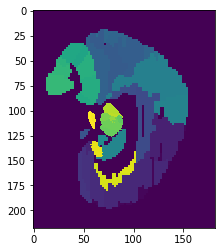

In [26]:
plt.imshow(aal[100,:,:])

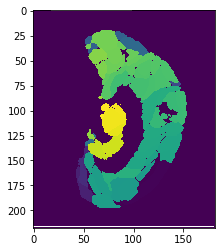

In [27]:
plt.imshow(aicha[100,:,:])

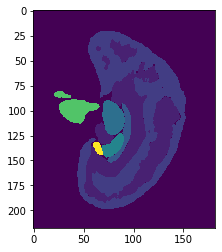

In [28]:
plt.imshow(harvard_oxford_sub[100,:,:])

## 3. Load json to do the experiment in a group of regions

In [31]:
with open('aal_ho_difference.json') as f:
    data = json.load(f)

In [38]:
def process_region(final_num, atlas, region_num):
    return final_num*((atlas==region_num).astype(np.uint8))

In [47]:
new_atlas = np.zeros(aal_transformed.shape)
aal_dif_df = {"name":[], "index":[]}
for i, r in enumerate(data):
    region_data = data[r]
    ho_data = region_data["A"][0]
    for ri in region_data["B"]:
        partial_vol=process_region(i+1, aal_transformed, ri["region_number"])
        new_atlas+=partial_vol
    aal_dif_df["name"].append(ho_data["region_name"])
    aal_dif_df["index"].append(i+1)
aal_dif_df = pd.DataFrame(aal_dif_df).to_csv("aal_combined.csv", index=False)

In [48]:
new_atlas_nifti = nib.Nifti1Image(new_atlas, ho_raw.affine)
nib.save(new_atlas_nifti, 'aal_combined.nii.gz')